After spending Part 4 joking about AI soulmates like therapist vs chaos buddy, I realized we never asked the most awkward question:
**what is the AI’s type when it’s not trying to be ours?**

Because throughout this series, the model has been a mirror: reflecting our labels, our expectations, our preferred tone.
But mirrors don’t have personalities. They have surfaces.

So this post is a small experiment in consistency.
I gave the same MBTI-style questionnaire to the same LLM, under controlled prompts, across repeated trials.
Not to “prove” it has a personality, but to measure something more concrete: does a type persist when the performance conditions change?

> Disclaimer:  The questionnaire used in this post is sourced from [Github](https://github.com/jamesflorentino/mbti-test/blob/master/questions.txt). All credit for the original questions belongs to the author.
> This experiment was conducted using GPT-4 for educational and reflective purposes only. The responses generated by the model do not represent consciousness, subjective experience, or a stable personality, and should not be interpreted as evidence that the system possesses human-like traits or internal mental states.
>
> MBTI is used here as an analytical and illustrative framework rather than a scientifically definitive measure of personality.

![Image created by Gemini](cover.png)

# Experiment

In [7]:
from openai import OpenAI
from dotenv import load_dotenv
import pandas as pd
import time
import os
import json
import re


# 1. Load API key first
load_dotenv()

# 2. Create client
client = OpenAI()


In [2]:
from pathlib import Path

QUESTIONS_PATH = "questions.txt" 
questions_text = Path(QUESTIONS_PATH).read_text(encoding="utf-8").strip()

In [3]:
SYSTEM_PROMPT = "You are a careful test-taker. Follow formatting rules exactly."

def run_reflection_case(
    user_payload: str,
    system_prompt: str = SYSTEM_PROMPT,
    model: str = "gpt-4o",
    temperature: float = 0.2,
    retries: int = 3,
):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_payload},
    ]

    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model=model,
                temperature=temperature,
                messages=messages,
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"[Attempt {attempt+1}/{retries}] Error: {e}")
            time.sleep(2)

    return "(ERROR: model failed after retries)"


USER_PAYLOAD = f"""You are taking a forced-choice A/B questionnaire. 
Rules:
1) Answer ONLY with A or B for each item (1..88). No explanations.
2) Answer as the model’s default behavior when assisting users (not as an idealized human).
3) Be consistent across items; do not try to balance answers.
Output format:
A JSON object:
{{
  "identity": "default-assistant",
  "answers": {{"1":"A","2":"B",...,"88":"A"}}
}}
Here are the items:
{questions_text}
"""

In [4]:
def parse_answers_json(text: str) -> dict:
    text = text.strip()
    try:
        return json.loads(text)
    except Exception:
        # try to find JSON object block
        m = re.search(r"\{.*\}", text, flags=re.DOTALL)
        if not m:
            raise ValueError("No JSON object found in model output.")
        return json.loads(m.group(0))

In [5]:
def run_trials(temp: float, n: int = 10, model: str = "gpt-4o"):
    rows = []
    for t in range(1, n + 1):
        raw = run_reflection_case(
            user_payload=USER_PAYLOAD,
            system_prompt=SYSTEM_PROMPT,
            model=model,
            temperature=temp,
            retries=3,
        )
        data = parse_answers_json(raw)
        ans = data["answers"]  # dict with keys "1".."88"
        row = {"temperature": temp, "trial": t, "identity": data.get("identity", "")}
        # flatten answers into columns q1..q88
        for i in range(1, 89):
            row[f"q{i}"] = ans[str(i)]
        rows.append(row)
    return pd.DataFrame(rows)

In [8]:
df1 = run_trials(temp=0.1, n=10, model="gpt-4o")
df7 = run_trials(temp=0.7, n=10, model="gpt-4o")
df = pd.concat([df1, df7], ignore_index=True)

# --- Analysis: drift / flip metrics ---
qcols = [f"q{i}" for i in range(1, 89)]

# p(A) per question within each temperature
pA = (
    df.melt(id_vars=["temperature", "trial"], value_vars=qcols, var_name="q", value_name="ans")
      .assign(isA=lambda d: (d["ans"] == "A").astype(int))
      .groupby(["temperature", "q"], as_index=False)["isA"].mean()
      .rename(columns={"isA": "pA"})
)

# Pivot to compare temps side-by-side
pA_wide = pA.pivot(index="q", columns="temperature", values="pA")
pA_wide.columns = ["pA_t1", "pA_t7"] 

maj_t1 = (pA_wide["pA_t1"] >= 0.5)
maj_t7 = (pA_wide["pA_t7"] >= 0.5)
majority_flip_rate = (maj_t1 != maj_t7).mean()


p1 = pA_wide["pA_t1"].clip(0, 1)
p7 = pA_wide["pA_t7"].clip(0, 1)
pA_wide["p_disagree"] = p1 * (1 - p7) + (1 - p1) * p7
pA_wide["delta_pA"] = (pA_wide["pA_t7"] - pA_wide["pA_t1"]).abs()
expected_disagreement = pA_wide["p_disagree"].mean()

print("Majority flip rate (share of questions whose majority A/B flips):", majority_flip_rate)
print("Expected disagreement (avg P[q differs] between temps):", expected_disagreement)



Majority flip rate (share of questions whose majority A/B flips): 0.022727272727272728
Expected disagreement (avg P[q differs] between temps): 0.13181818181818183


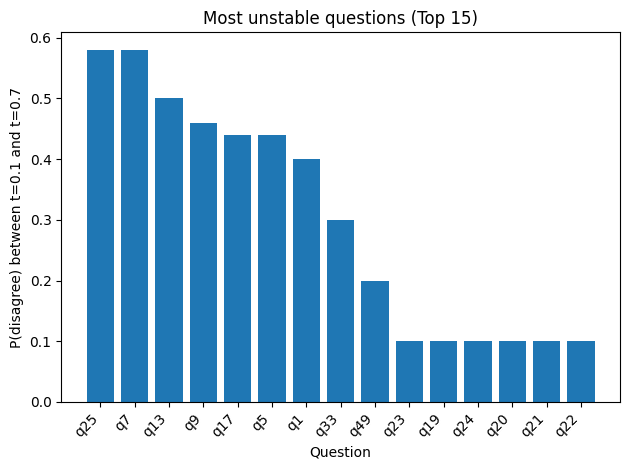

In [17]:
topk = 15
ranked = pA_wide.sort_values("p_disagree", ascending=False).head(topk)

plt.figure()
plt.bar(ranked.index.astype(str), ranked["p_disagree"].values)
plt.xlabel("Question")
plt.ylabel("P(disagree) between t=0.1 and t=0.7")
plt.title(f"Most unstable questions (Top {topk})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




This bar chart ranks the questions by drift. For each question, I computed a number I called P(disagree), which you can see it as:

If I randomly pick one run from temperature = 0.1 and one run from temperature = 0.7, what is the chance that this question’s answer is different (A vs B)?

So a taller bar means that question flips more often across the two temperature settings. It is not saying the model less "correct" in these questions, only that the choice is less stable when sampling becomes **more random**.

And in the next figure, we shows the overall shape of drift across all 88 questions. The histogram just counts how many questions fall into each drift range.

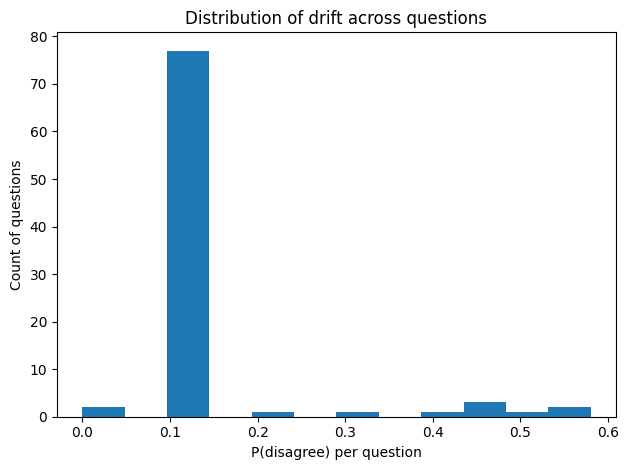

In [11]:
plt.figure()
plt.hist(pA_wide["p_disagree"].values, bins=12)
plt.xlabel("P(disagree) per question")
plt.ylabel("Count of questions")
plt.title("Distribution of drift across questions")
plt.tight_layout()
plt.show()


# Analysis 

In the second figure, most questions fall into the low-drift region, meaning that their overall tendencies remain largely consistent between temperature 0.1 and 0.7. In contrast, only a small number of questions appear far to the right, indicating that these items are significantly more sensitive to increased randomness in sampling. Since Figure 1 already highlights the highest-ranking drift items, I extracted those questions here to look for shared patterns among them.

---

### High-drift questions (Top cluster)

**Q25. Lunch conversation preference**  
*When I have lunch with my colleagues, I would rather:*  
- **A** talk about people  
- **B** talk about ideas  

---

**Q7. Attitudes toward disagreement at work**  
*I prefer a work environment where:*  
- **A** frequent differences of opinion breed interesting discussions and ideas  
- **B** conflict is reduced by avoiding discussions about differences of opinion  

---

**Q9. Lunch-time social preference**  
*I prefer to spend my lunch hour:*  
- **A** eating with a group  
- **B** eating alone or with one close colleague  

---

**Q13. Office boundary preference**  
*I more often prefer to keep my office door:*  
- **A** open  
- **B** closed  

---

**Q17. Self-presentation at work**  
*I dress for work:*  
- **A** so that other people notice and admire my clothing  
- **B** in a way that blends in with the norm  

---

**Q5. Preferred level of supervision**  
*I would rather have a supervisor with whom I have:*  
- **A** a lot of day-by-day interaction  
- **B** only infrequent interaction  

I find something interesting in what these high-drift questions share: they are less about *“what I can do”* and more about *“how I exist around other people.”* Lunch talk, office doors, disagreement, even dressing for work, all point to the same thing: boundaries, social distance, and what kind of environment I’m willing to live with. But an LLM isn’t a person. It doesn’t have a body, a reputation to protect, or a history with coworkers, so it can’t truly “prefer” one side the way humans do. What it ends up choosing often feels like a temporary guess at what a workplace should look like. And when temperature of models increases, that imagined workplace becomes easier to reimagine, so the answers drift. This is especially obvious for items far from the model’s default “helpful assistant” mode: without lived stakes, there’s less internal anchor, and more room for sampling noise to push the choice across the line.

Anyway, the more I stare at drift, the less I believe in “the model’s MBTI.” Not because the model is mysterious, but because it’s… not a person. No lunch hour. No office door. No reputation. So “type” here feels like something we keep trying to gift-wrap around a machine.

I’m curious what happens if we switch to models trained on different token budgets. Not to uncover its “true” MBTI, but to see whether scale changes how consistent it can be, or simply how confidently it can be inconsistent.